In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

In [2]:
class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state = None):
        self.params = params
        self.T = T
        self.Nx = Nx
        self.Nt = Nt
        self.init_state = init_state

        #Wiener Process by default
        self.bxt = lambda x: 0
        self.sigmaxt = lambda x: 1

    def sampler_init_state(self):
        return np.zeros(self.Nx)

    def EulerSolution(self):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.sampler_init_state()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            dwt = np.random.normal(0, 1, size = self.Nx) * np.sqrt(dt)
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt
        return t_data, x_data

Task 1. Use the stochastic integral Ito, $N=1000$ to simulate and plot a path with $X_0 = 10$ of

the Ornstein-Uhlenbeck process, $\mathbb{\theta} = (-5.0, 0.0, 3.5)$;

the Cox-Ingersoll-Ross process, $\mathbb{\theta} = (2.00, 0.20, 0.15)$;

the Black-Scholes-Merton process, $\mathbb{\theta} = (1.0, 0.2)$.
   

In [3]:
class OrnsteinUhlenbeckProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta, mu, sigma]
        self.bxt = lambda x: self.params[0] * (self.params[1] - x)
        self.sigmaxt = lambda x: self.params[2]

    def sampler_init_state(self):
        return self.params[1] * np.ones(self.Nx)


class CoxIngersollRossProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2, theta3]
        self.bxt = lambda x: self.params[0] - self.params[1] * x
        self.sigmaxt = lambda x: self.params[2] * np.sqrt(np.maximum(x, 0))

    def sampler_init_state(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)


class BlackScholesMertonProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2]
        self.bxt = lambda x: self.params[0] * x
        self.sigmaxt = lambda x: self.params[1] * x

    def sampler_init_state(self):
        return np.ones(self.Nx)

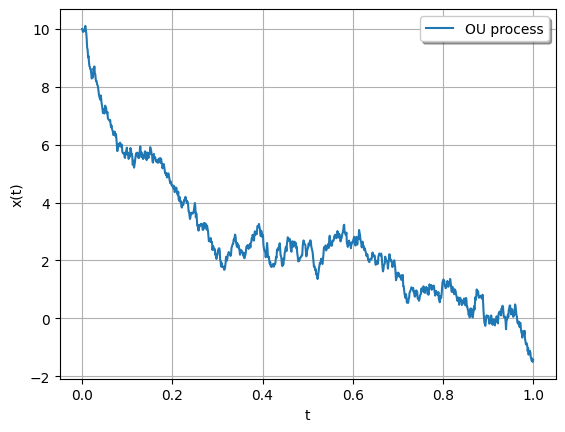

In [4]:
T = 1
Nx = 1
Nt = 1000

init_state = 10 * np.ones(Nx)

theta = 5
mu = 0
sigma = 3.5
params = [theta, mu, sigma]

OUProcess = OrnsteinUhlenbeckProcess(params, T, Nx, Nt, init_state)
t_data, x_data = OUProcess.EulerSolution()
plt.plot(t_data, x_data, label = 'OU process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

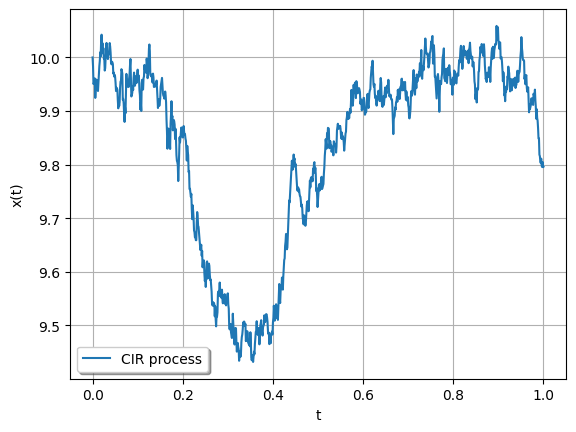

In [5]:
theta1 = 2
theta2 = 0.2
theta3 = 0.15
params = [theta1, theta2, theta3]

CIRProcess = CoxIngersollRossProcess(params, T, Nx, Nt, init_state)
t_data, x_data = CIRProcess.EulerSolution()
plt.plot(t_data, x_data, label = 'CIR process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

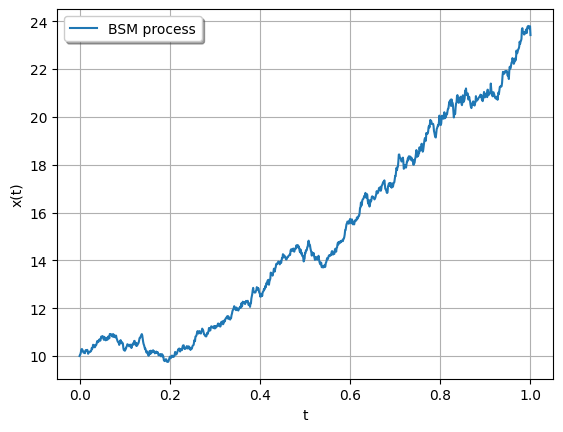

In [6]:
theta1 = 1.0
theta2 = 0.2
params = [theta1, theta2]

BSMProcess = BlackScholesMertonProcess(params, T, Nx, Nt, init_state)
t_data, x_data = BSMProcess.EulerSolution()
plt.plot(t_data, x_data, label = 'BSM process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task 2. Compute a confidence interval of the CIR process from the previous task. Plot the paths and a confidence interval.

In [7]:
def zeta(sigma, theta, t, s):
    return sigma**2 / (4 * theta) * (1 - np.exp(-theta * (t - s)))

def CIRbounds(alpha_interval, params, t, s, xs):
    theta1, theta2, theta3 = params[0], params[1], params[2]
    theta = theta2
    beta = theta1 / theta2
    sigma = theta3

    k = 4  / sigma**2 * theta * beta
    lambd = 4 * theta / sigma**2  * np.exp(-theta * (t - s)) / (1 - np.exp(-theta * (t - s))) * xs
    ksi = norm.ppf(1 - alpha_interval / 2)

    b1 = zeta(sigma, theta, t, s) * (k + lambd - ksi * np.sqrt(2 * (k + 2 * lambd)))
    b2 = zeta(sigma, theta, t, s) * (k + lambd + ksi * np.sqrt(2 * (k + 2 * lambd)))
    return [b1, b2]


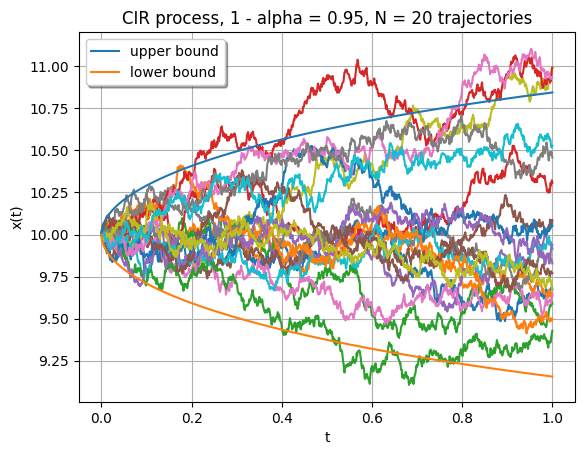

In [8]:
theta1 = 2
theta2 = 0.2
theta3 = 0.15
params = [theta1, theta2, theta3]

Nx = 20

x0 = 10
init_state = x0 * np.ones(Nx)
alpha_interval = 0.05

CIRProcess = CoxIngersollRossProcess(params, T, Nx, Nt, init_state)
t_data, x_data = CIRProcess.EulerSolution()
for k in range(0, Nx):
    plt.plot(t_data, x_data[:,k])

low_bound_data = np.zeros_like(t_data)
up_bound_data = np.zeros_like(t_data)

for i in range(1, len(t_data)):
    bounds = CIRbounds(alpha_interval, params, t_data[i], 0, x0)
    low_bound_data[i] = bounds[0]
    up_bound_data[i] = bounds[1]
low_bound_data[0] = x0
up_bound_data[0] = x0
plt.plot(t_data, up_bound_data, label = f"upper bound")
plt.plot(t_data, low_bound_data, label = f"lower bound")

plt.title(f"CIR process, 1 - alpha = {1-alpha_interval}, N = {Nx} trajectories")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task 3. For the Ornstein-Uhlenbeck process
$$
dX_t = \theta(\mu - X_t)dt + \sigma dW_t, \quad \theta = 1, \quad \mu = 1.2, \quad \sigma = 0.3
$$
generate three paths: $X_0 = 0.0, 2.0, \mathcal{N}\left(\mu, \frac{\sigma^2}{2\theta}\right)$ and plot in graph.


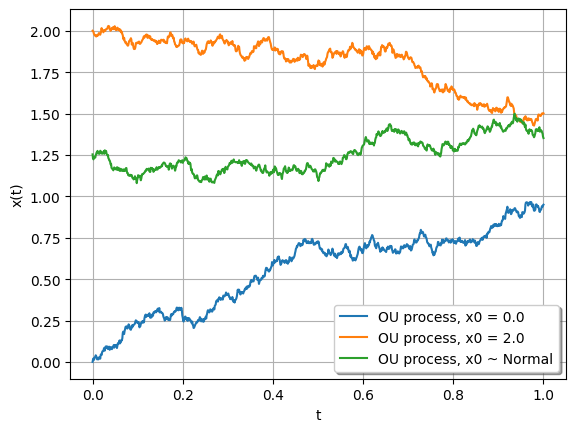

In [9]:
T = 1
Nx = 1
Nt = 1000

theta = 1
mu = 1.2
sigma = 0.3
params = [theta, mu, sigma]

x0 = 0.0
init_state = x0 * np.ones(Nx)
OUProcess = OrnsteinUhlenbeckProcess(params, T, Nx, Nt, init_state)

t_data, x_data = OUProcess.EulerSolution()
plt.plot(t_data, x_data, label = f'OU process, x0 = {x0}')

x0 = 2.0
init_state = x0 * np.ones(Nx)
OUProcess = OrnsteinUhlenbeckProcess(params, T, Nx, Nt, init_state)

t_data, x_data = OUProcess.EulerSolution()
plt.plot(t_data, x_data, label = f'OU process, x0 = {x0}')


init_state = np.random.normal(mu, sigma**2/(2 * theta), size = Nx)
OUProcess = OrnsteinUhlenbeckProcess(params, T, Nx, Nt, init_state)

t_data, x_data = OUProcess.EulerSolution()
plt.plot(t_data, x_data, label = f'OU process, x0 ~ Normal')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task 4.1. Define a path with the stationary distribution from the graph and prove mathematically.

In [10]:
# your code for prove

### Task 4.  Design a process that stays in the interval $[0, 1]$ and mean-reverts around $1/2$, generate a path and plot it in graph. Prove your solution.




Hint
$$
\mu(x) = \theta (1/2 - x), \quad \sigma(x) = \sigma \cdot x (1-x).
$$

That is
$$
dx = \theta (1/2 - x )dt + \sigma \cdot x (1-x) dW.
$$
Note: diffusion goes to zero at boundaries $\sigma(0) = \sigma(1) = 0$ and
mean-reverts  $⇒$ always stay in $[0, 1]$.

In [230]:
# theta - mean-reversion speed
def DesingProcess(theta, sigma, x0, T, N):
    dt = T / N  

    time = np.linspace(0, T, N+1)
    x = np.zeros(N+1)
    x[0] = x0

    for i in range(1, N+1):
        dw = np.random.normal(0, np.sqrt(dt))  # Brownian motion increment
        x[i] = x[i-1] + theta * (0.5 - x[i-1]) * dt + sigma * x[i-1] * (1 - x[i-1]) * dw
        x[i] = np.clip(x[i], 0, 1)
    
    return time, x
    
    

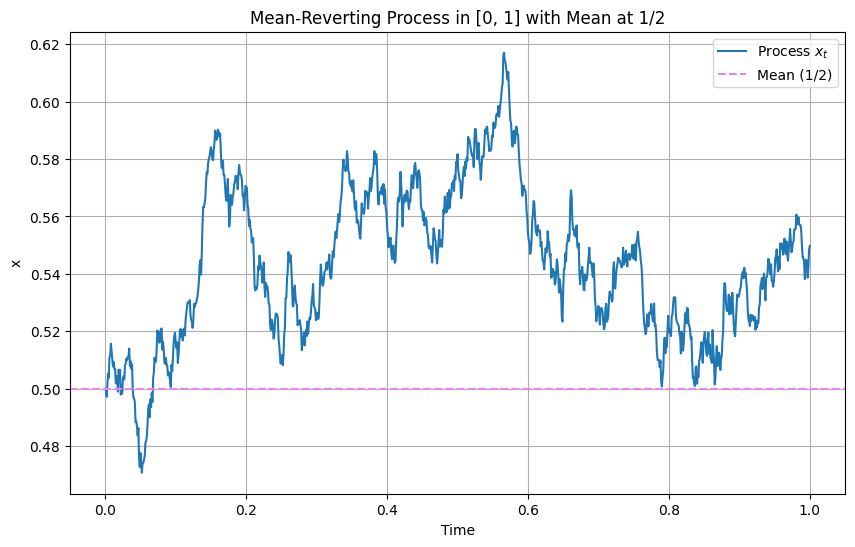

In [231]:
theta, sigma, x0, T, N = 2, 0.5, 0.5, 1, 1000    
time, x = DesingProcess(theta, sigma, x0, T, N)

plt.figure(figsize=(10, 6))
plt.plot(time, x, label=r'Process $x_t$')
plt.axhline(0.5, color='violet', linestyle='--', label='Mean (1/2)')
plt.xlabel('Time')
plt.ylabel('x')
plt.title('Mean-Reverting Process in [0, 1] with Mean at 1/2')
plt.legend()
plt.grid(True)
plt.show()

### Task 5. Using the class template from Task 1, create classes and plot graphs for the following processes:


1.   Modified CIR model;
2.   Chan-Karolyi-Longstaff-Sanders family of models;
1.   Nonlinear mean reversion Ait-Sahalia model;
2.   Jacobi diffusion process;
1.   Ahn and Gao (inverse of Feller’s square root) model;
2.   Radial Ornstein-Uhlenbeck process.


In [114]:
import matplotlib.pyplot as plt
import numpy as np

def plot_process(process, process_name):
    t_data, x_data = process.EulerSolution()  # Получаем данные по времени и процессу
    plt.plot(t_data, x_data, label=process_name)  # Строим график

    plt.legend(loc='best', fancybox=True, shadow=True)  # Добавляем легенду
    plt.xlabel("t")  # Подпись по оси x
    plt.ylabel("x(t)")  # Подпись по оси y
    plt.grid(True)  # Включаем сетку
    plt.show()  # Показываем график


---

In [170]:
class ModifiedCIRProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        assert  params[0] + params[1]**2 > 0, 'Invalid Values'
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2]
        self.bxt = lambda x: -self.params[0] * x
        self.sigmaxt = lambda x: self.params[1] * np.sqrt(1 + x**2)

    def sampler_init_state(self):
        return -np.ones(self.Nx)  # положительное начальное состояние (например, 1)


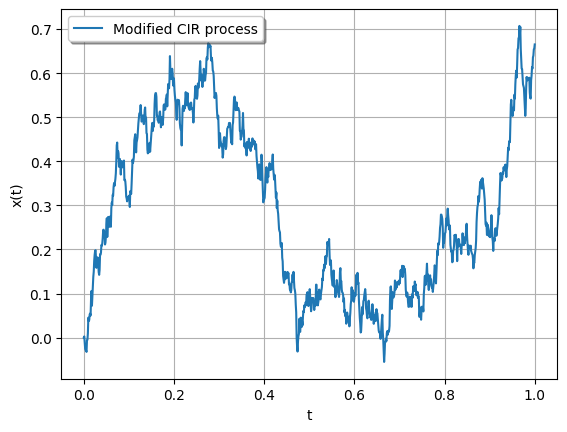

In [140]:
theta1 = 2
theta2 = 0.5
x0 = 0
Nx = 1
Nt = 1000
T = 1.0

params = [theta1, theta2]
init_state = x0 * np.ones(Nx)

ModifiedCIR = ModifiedCIRProcess(params, T, Nx, Nt, init_state)
plot_process(ModifiedCIR, 'Modified CIR process')

In [189]:
class ChanKarolyiLongstaffSandersProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        assert params[0] > 0 and params[1] > 0 and params[2] > 0 and params[3] > 1/2, 'Invalid Values'
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2, theta3, theta4]
        self.bxt = lambda x: self.params[0] + self.params[1] * x
        self.sigmaxt = lambda x: self.params[2] * x ** self.params[3]

    def sampler_init_state(self):
        return np.ones(self.Nx) * 1  # начальное состояние > 0



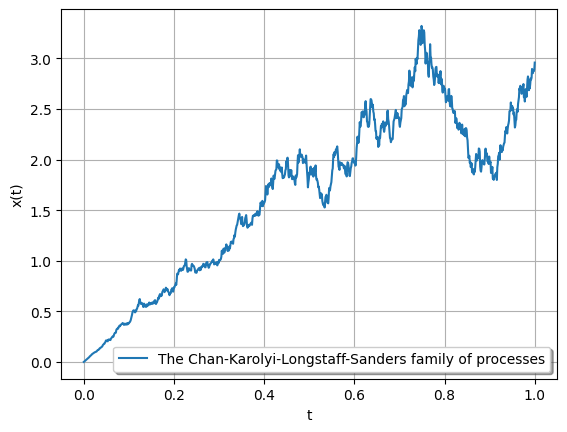

In [190]:
theta1, theta2, theta3, theta4 = 4, 0.2, 0.7, 1
x0 = 0
Nx = 1
Nt = 1000
T = 1.0

params = [theta1, theta2, theta3, theta4 ]
init_state = x0 * np.ones(Nx)

ChanKarolyiLongstaffSanders = ChanKarolyiLongstaffSandersProcess(params, T, Nx, Nt, init_state)
plot_process(ChanKarolyiLongstaffSanders, 'The Chan-Karolyi-Longstaff-Sanders family of processes')

In [200]:
class AitSahaliaProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [alpha_-1, alpha_0, alpha_1, alpha_2, beta_1, rho]
        self.bxt = lambda x: (self.params[0] / x) + self.params[1] + self.params[2] * x + self.params[3] * x**2
        self.sigmaxt = lambda x: self.params[4] * np.maximum(x, 1e-8) ** self.params[5]

    def sampler_init_state(self):
        return np.ones(self.Nx) * 1  # часто выбирается в пределах среднего значения процесса.

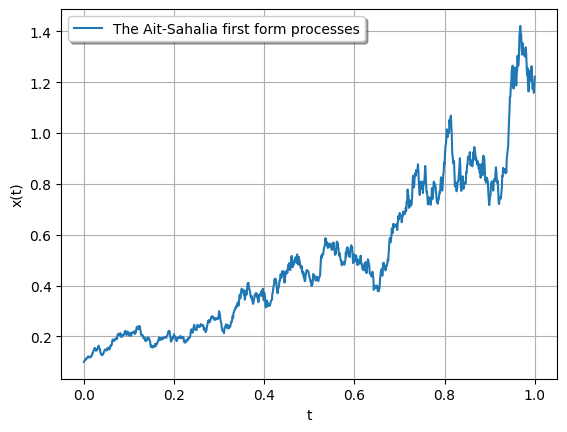

In [204]:
alpha_0, alpha_1, alpha_2, alpha_3, beta_1, rho= 0.1, 0.3, 1, 0.4, 1, 1
x0 = 0.1
Nx = 1
Nt = 1000
T = 1.0

params = [alpha_0, alpha_1, alpha_2, alpha_3, beta_1, rho]
init_state = x0 * np.ones(Nx)

AitSahalia = AitSahaliaProcess(params, T, Nx, Nt, init_state)
plot_process(AitSahalia, 'The Ait-Sahalia first form processes')

In [205]:
class JacobiDiffusionProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        assert params[0] > 0, 'Invalid Values'
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta]
        self.bxt = lambda x: -self.params[0] * (x - 0.5)
        self.sigmaxt = lambda x: np.sqrt(self.params[0] * np.maximum(x * (1 - x), 1e-8))

    def sampler_init_state(self):
        return np.ones(self.Nx) * 0.7  # Начальное состояние в пределах [0, 1], например, 0.5 


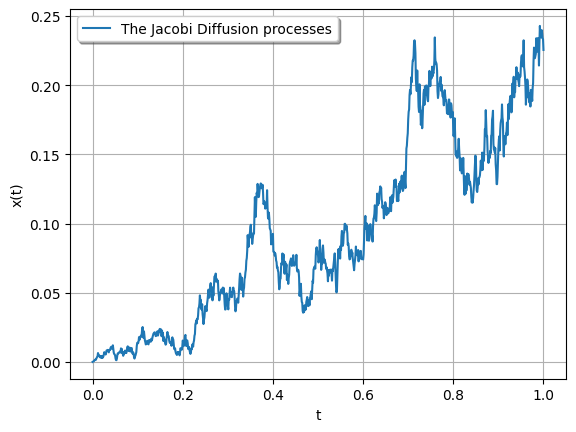

In [208]:
theta = 0.4
x0 = 0
Nx = 1
Nt = 1000
T = 1.0

params = [theta]
init_state = x0 * np.ones(Nx)

JacobiDiffusion = JacobiDiffusionProcess(params, T, Nx, Nt, init_state)
plot_process(JacobiDiffusion, 'The Jacobi Diffusion processes')

In [212]:
class AhnGaoProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2, theta3]
        self.bxt = lambda x: x * (self.params[0] - (self.params[2]**3 - self.params[0] * self.params[1]) * x)
        self.sigmaxt = lambda x: self.params[2] * np.maximum(x, 1e-8) ** 1.5

    def sampler_init_state(self):
        return np.ones(self.Nx) * 1  # начальное положительное состояние


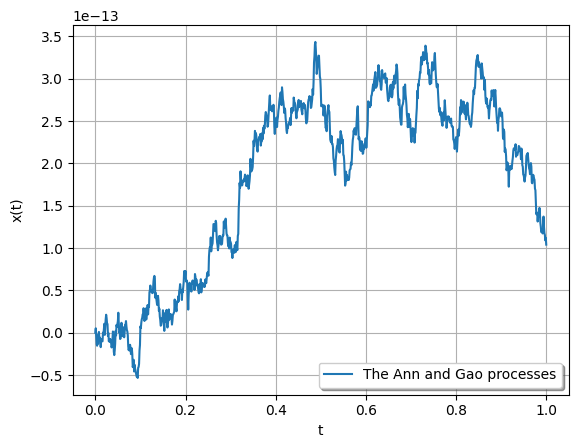

In [214]:
theta1, theta2, theta3 = 0.1, 0.3, 0.25
x0 = 0
Nx = 1
Nt = 1000
T = 1.0

params =  [theta1, theta2, theta3]
init_state = x0 * np.ones(Nx)

AhnGao = AhnGaoProcess(params, T, Nx, Nt, init_state)
plot_process(AhnGao, 'The Ann and Gao processes')

In [224]:
class RadialOrnsteinUhlenbeckProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta]
        self.bxt = lambda x: self.params[0] * x ** -1 - x
        self.sigmaxt = lambda x: 1  # коэффициент диффузии постоянный (стандартный винеровский процесс)

    def sampler_init_state(self):
        return np.ones(self.Nx) * 1  # Начальное состояние > 0 


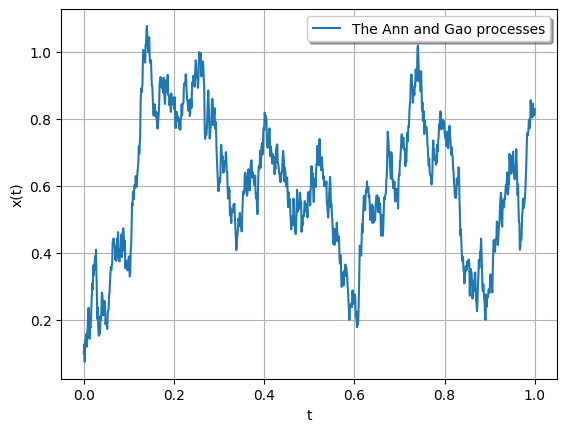

In [229]:
theta = 0.4
x0 = 0.1
Nx = 1
Nt = 1000
T = 1.0

params = [theta]
init_state = x0 * np.ones(Nx)

RadialOrnsteinUhlenbeck = RadialOrnsteinUhlenbeckProcess(params, T, Nx, Nt, init_state)
plot_process(RadialOrnsteinUhlenbeck, 'The Ann and Gao processes')

### Task 6.



Let $$X(t)=e^{-\kappa t} X_0 + \theta (1-e^{-\kappa t}) + \sigma e^{-\kappa t} \int_0^t e^{\kappa s}\sqrt{X(t)}dW(s)$$ be extract solution for CIR model.


 Expand the functionality of the class CoxIngersollRossProcess(StochasticProcess) and compute the first and second moments of the extract solution $\mathbb{E}\{X^n(t)\}$ using the general formula [Jafari, 2017]
$$
\mathbb{E}\{X^n(t)\} = \sum_{j=0}^{[n/2]}A^{n-2j}(t)B^{2j}(t)
\left(\frac{1}{2\kappa}(e^{2\kappa t} - 1)\right)^{2j}, \quad \forall n \in \mathbb{N},
$$
where $A(t)=e^{-\kappa t X_0} + \theta(1-e^{-\kappa t})$,
$B(t)=\sigma e^{-\kappa t}$, $[n/2]$ denotes the greatest integer less than or equal to $\frac{n}{2}$ and $\kappa=1$, $\theta =0.45$, $\sigma=1$.

Jafari M.A. [The Moments for Solution of the Cox-Ingersoll-Ross Interest Rate Model](https://www.sciepub.com/portal/downloads?doi=10.12691/jfe-5-1-4&filename=jfe-5-1-4.pdf) / M.A. Jafari, S. Abbasian // Journal of Finance
and Economics. – 2017. – Vol. 5, № 1. – P. 34—37

In [236]:
class CoxIngersollRossProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        # params = [kappa, theta, sigma]
        self.kappa = params[1]  
        self.theta = params[0]  
        self.sigma = params[2]  

        self.bxt = lambda x: self.kappa * (self.theta - x)
        self.sigmaxt = lambda x: self.sigma * np.sqrt(np.maximum(x, 0))

    def calculate_moments(self, t, X0, n):
        
        init_state = np.full(self.Nx, self.theta) # инициализация состояния до долгосрочного среднего

        # вычисление A(t) и B(t) для точного решения
        A_t = np.exp(-self.kappa * t) * X0 + self.theta * (1 - np.exp(-self.kappa * t))
        B_t = self.sigma * np.exp(-self.kappa * t)
        
        moment = 0
        
        # вычисление суммы в формуле Джафари
        for j in range((n // 2) + 1):
            A_term = A_t**(n - 2*j)
            B_term = B_t**(2*j)
            kappa_factor = (1 / (2 * self.kappa)) * (np.exp(2 * self.kappa * t) - 1)
            moment += A_term * B_term * (kappa_factor**(2 * j))
        
        return init_state, moment

    def first_moment(self, t, X0):
        """Compute the first moment E[X(t)]."""
        _, moment = self.calculate_moments(t, X0, 1)
        return moment

    def second_moment(self, t, X0):
        """Compute the second moment E[X^2(t)]."""
        _, moment = self.calculate_moments(t, X0, 2)
        return moment


In [240]:
theta, kappa, sigma = 0.45, 1, 1
params = [theta, kappa, sigma]
t = 1.0
x0 = 0.5
T = 1
Nx = 1  
Nt = 1000
init_state = np.array([0.5]) 

cir_process = CoxIngersollRossProcess(params, T, Nx, Nt, init_state)


first_moment = cir_process.first_moment(t, x0)
second_moment = cir_process.second_moment(t, x0)

print(f'1 moment : {first_moment}')
print(f'2 moment : {second_moment}')


1 moment : 0.46839397205857214
2 moment : 1.6004907586026225


### Task 7. Suppose we have a standard (zero-mean) Ornstein-Uhlenbeck process defined by

$$
dX_t = -\theta X_t dt + \sigma dW_t, \quad X_0 = x_0,
$$
where $\sigma$ is interpreted as the volatility, and $\theta$ is the speed of reversion.

Define a half-life at time $s$ as the time $h$ such that $𝔼(x_h|x_s)=\frac{1}{2}x_s$. That is, how long until half the deviation from the mean is, in expectation, lost.

This is easy to compute because
\begin{align}
  \frac{1}{2}x_s & =  𝔼(x_h|x_s) \\
                 & = x_s\exp(-\theta h)
\end{align}
and we can cancel the $x_s$ terms to give
\begin{align}
  \frac{1}{2} = \exp(-\theta h)
\end{align}
which rearranges to
\begin{align}
  h = \frac{\ln(2)}{\theta}
\end{align}
The cancellation of $x_s$ means that a half-life does not depend on either $s$ or $x_s$ and so we are entitled to call it "the" half-life of the process.

As one can see, the half-life is a constant for an Ornstein-Uhlenbeck process.



In [245]:
class OrnsteinUhlenbeckProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta, mu, sigma]
        self.bxt = lambda x: self.params[0] * (self.params[1] - x) 
        self.sigmaxt = lambda x: self.params[2] 

    def sampler_init_state(self):
        return self.params[1] * np.ones(self.Nx)

    def half_life(self):
        """Вычисление полувремени"""
        theta = self.params[0]
        return np.log(2) / theta

In [249]:
theta, mu, sigma = 1.0, 0.0, 0.5
params = [theta, mu, sigma]  
T = 1
Nx = 5  
Nt = 100


ou_process = OrnsteinUhlenbeckProcess(params, T, Nx, Nt)
half_life_value = ou_process.half_life()
t_data, simulated_data = ou_process.EulerSolution()

# Вывод полувремени и первых 5 значений симуляции
print(f"Полувремя: {half_life_value:.4f}")
print("Временные данные:", t_data)
print("Симулированные данные (первые 5 значений для каждого процесса):")
# print(simulated_data[:, :5])

Полувремя: 0.6931
Временные данные: [0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.  ]
Симулированные данные (первые 5 значений для каждого процесса):


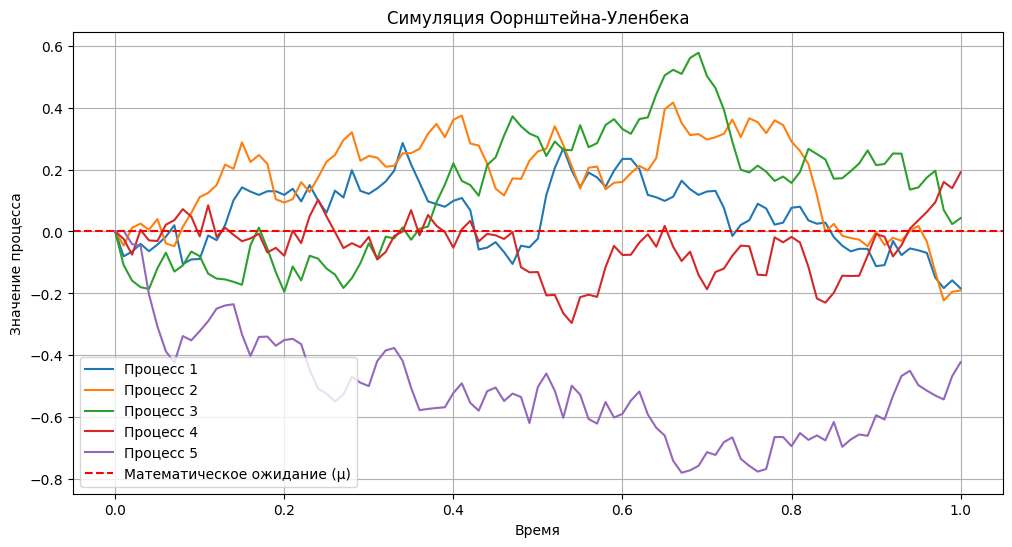

In [250]:
plt.figure(figsize=(12, 6))
for i in range(Nx):
    plt.plot(t_data, simulated_data[:, i], label=f'Процесс {i + 1}')
plt.title('Симуляция Оорнштейна-Уленбека')
plt.xlabel('Время')
plt.ylabel('Значение процесса')
plt.axhline(y=params[1], color='r', linestyle='--', label='Математическое ожидание (μ)')
plt.legend()
plt.grid()
plt.show()